In [ ]:
import json

from helpers.dataset import get_dataset

from helpers.dataset import MUFFIN_TASK, CUSTOM_TASKS, CROSS_TASK_TASKS

import tiktoken

def count_tokens(text, model="gpt-4"):
    encoding = tiktoken.encoding_for_model(model)
    n_tokens = len(encoding.encode(text))
    return n_tokens

### find the largest (token-wise) tutorial
all_tasks = CUSTOM_TASKS + [MUFFIN_TASK] + CROSS_TASK_TASKS
max_token_tutorial = 0
for task in all_tasks:
    dataset = get_dataset(task)
    for tutorial in dataset:
        total_tokens = 0
        for script in tutorial["transcript"]:
            text = script["text"]
            start = script["start"]
            end = script["end"]
            cur_line = json.dumps({
                "piece_id": "[SS12345]",
                "label_id": "][[]]label[][][]",
                "content": text,
                "start": start,
                "end": end,
                "subtype": "Opening",
                "type": "LOLOL"
            })
            total_tokens += count_tokens(cur_line)
        max_token_tutorial = max(max_token_tutorial, total_tokens)
print(max_token_tutorial)


In [ ]:
import json
from pydantic import BaseModel, Field
from pydantic.json_schema import model_json_schema

class Script(BaseModel):
    piece_id: str = Field(..., description="The unique identifier for the script piece")
    label_id: str = Field(..., description="The unique identifier for the label")
    content: str = Field(..., description="The content of the script piece")
    start: float = Field(..., description="The start time of the script piece")

json_str = model_json_schema(Script)
print(json.dumps(json_str, indent=2))

In [ ]:
import itertools

ingredients = [
    "rolled oats",
    "1/2 cup flour",
    "1/2 cup brown sugar",
    "roasted pumpkin seeds",
    "softened butter"
]

def factorial(n):
    if n == 0:
        return 1
    return n * factorial(n-1)

template = "In a small bowl, add {}, then {}, then {}, then {}, and finally {}."

permutations = itertools.permutations(range(len(ingredients)), len(ingredients))

texts = []
for p in permutations:
    cur_template = template.format(*[ingredients[i] for i in p])
    texts.append(cur_template)


from helpers import perform_embedding
import numpy as np
embedding_method = "openai"

embeddings = perform_embedding(embedding_method, texts)
similarities = np.dot(embeddings, embeddings.T)

In [ ]:
### visualize the embeddings similarities in 2D
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(similarities, cmap='viridis')
plt.colorbar(label='Cosine Similarity')

In [ ]:
from enum import Enum
import json

class MetricScale(str, Enum):
    LIKERT_7 = "likert-7"
    LIKERT_5 = "likert-5"
    LIKERT_3 = "likert-3"
    BINARY = "binary"
    COMPARISON = "comparison"

text = str(MetricScale.LIKERT_7)
if text == MetricScale.LIKERT_7:
    print("yes")
else:
    print("no")

print(MetricScale.LIKERT_7)


[[3063, 1], [145, 1], [51, 1], [19, 1], [18, 1], [5, 1], [4, 10], [4, 6]]


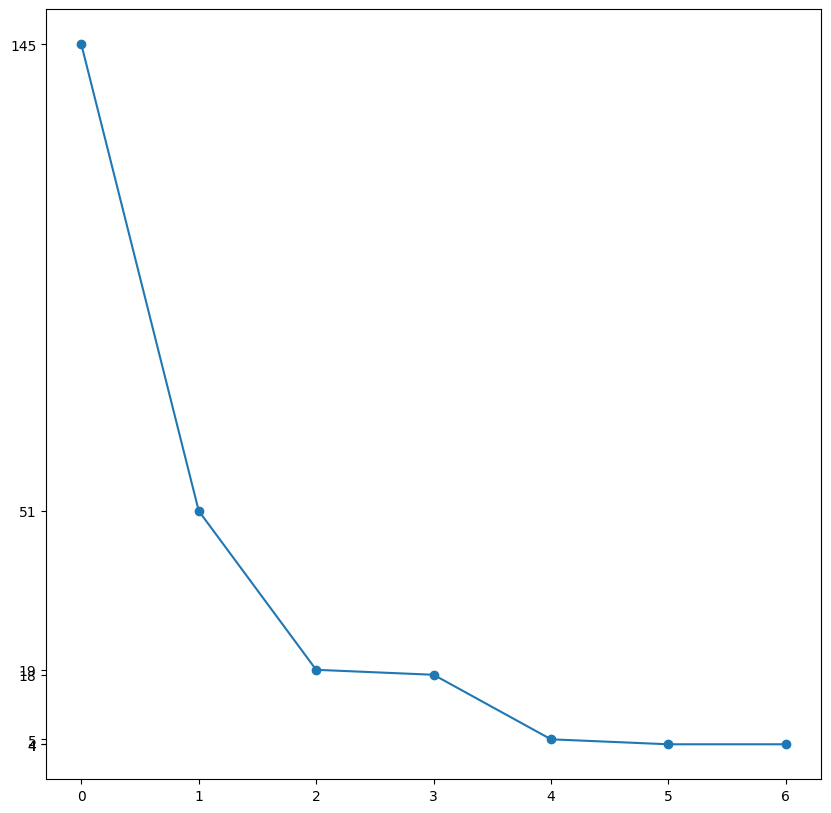

In [23]:
import re
import matplotlib.pyplot as plt
import math

def parse_file(file_path, reg):
    lines = []
    with open(file_path, "r") as f:
        for it, line in enumerate(f):
            if reg in line:
                lines.append((it, line))
    return lines

lines = parse_file("./static/results/framework/full_run_5/split_how_to_make_a_sushi_roll.txt", "unit size")

def extract_numbers(line):
    numbers = re.findall(r'\d+', line)
    return [int(number) for number in numbers]

last_numbers = []
for i in range(len(lines)-1):
    if lines[i+1][0] - lines[i][0] > 1:
        line = lines[i][1]
        numbers = extract_numbers(line)
        last_numbers.append(numbers)
last_numbers.append(extract_numbers(lines[-1][1]))

print(last_numbers)
unit_sizes = [numbers[0] for numbers in last_numbers]
unit_sizes = unit_sizes[1:]

fig = plt.figure(figsize=(10, 10))
plt.plot(unit_sizes, marker="o")
plt.yticks(unit_sizes)
plt.show()

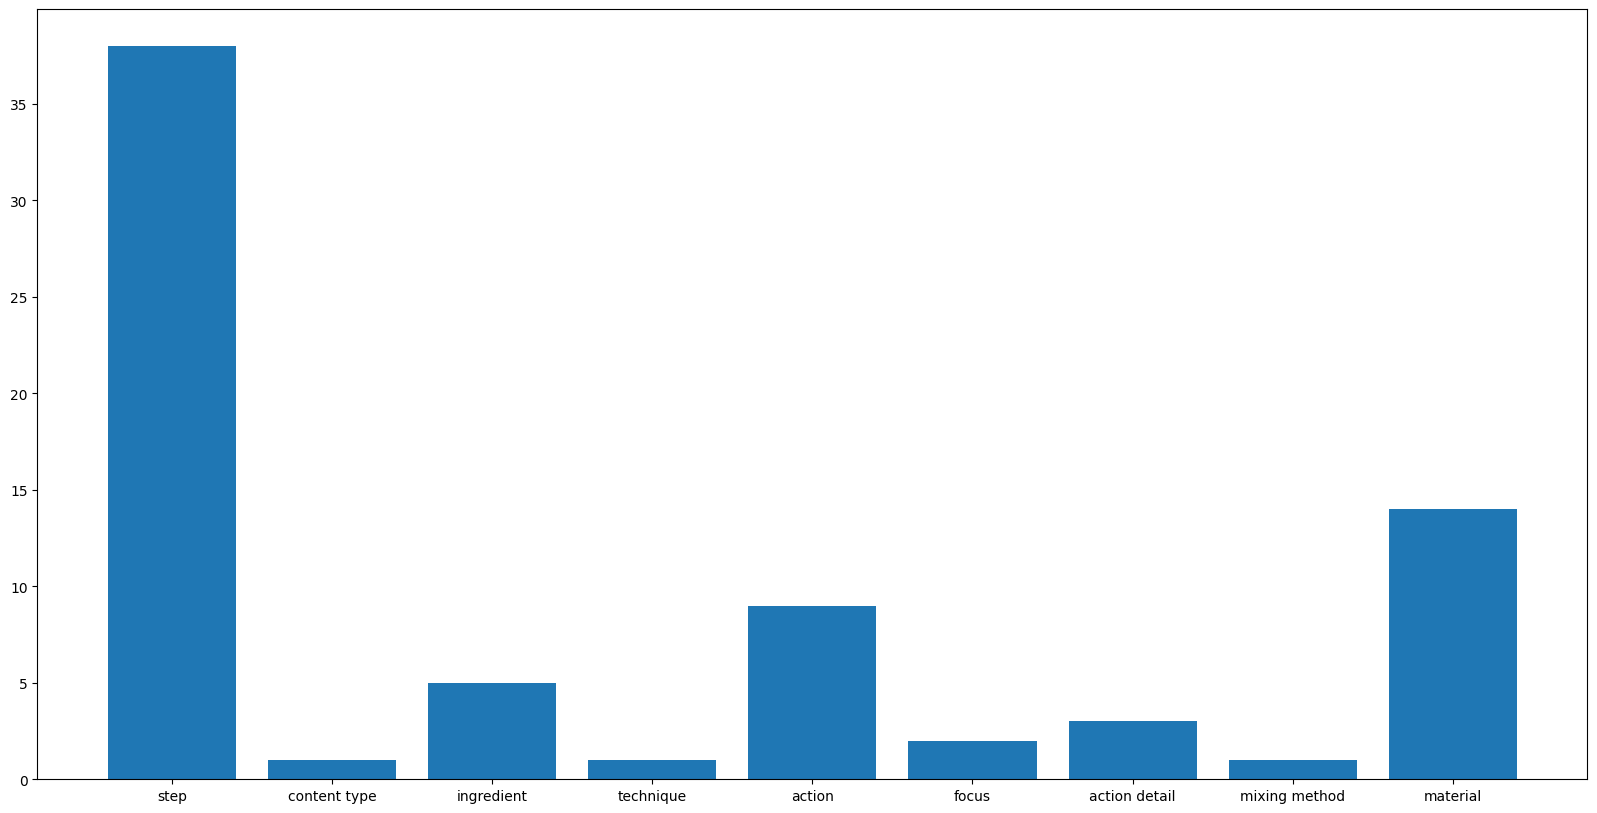

This aspect segments the tutorial transcript into distinct sequential steps or stages involved in making a sushi roll. Each segment corresponds to a specific, meaningful action or group of closely related actions in the preparation, assembly, cooking, and serving process of the sushi roll.
Segments correspond to distinct, sequential steps or stages in the sushi making process, each representing a meaningful and complete action or group of closely related actions, ordered temporally from start to finish.


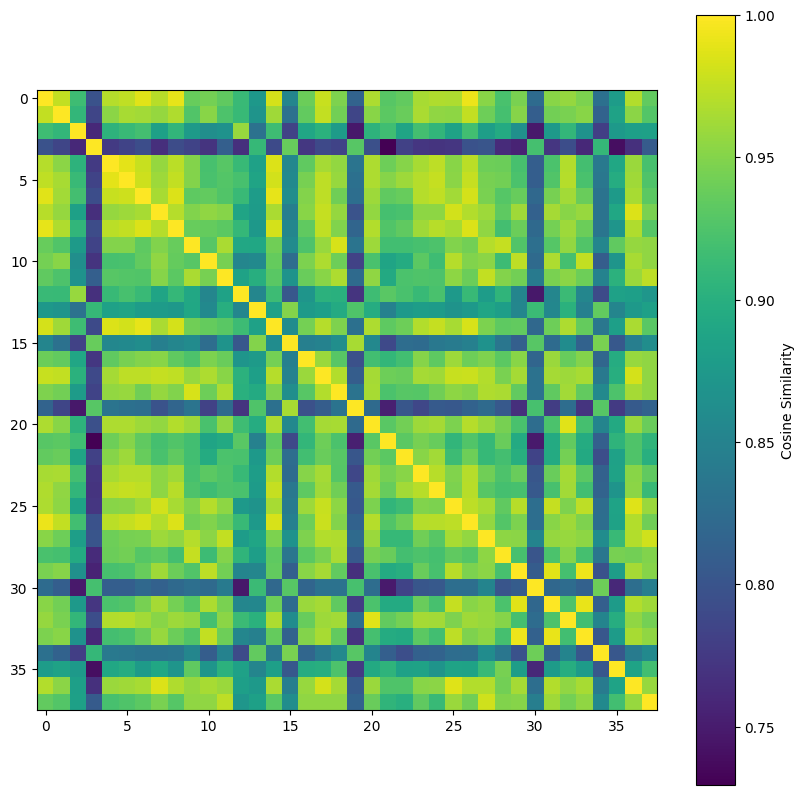

In [39]:
import json
from collections import defaultdict

def facet_frequencies(facets):
    facet_frequencies = defaultdict(list)
    for facet in facets:
        facet_title = facet["title"].lower()
        facet_frequencies[facet_title].append(facet["definition"])
    return facet_frequencies

result = json.load(open("./static/results/framework/how_to_make_a_sushi_roll/split_results_full_run_6.json"))
freqs = facet_frequencies(result["facet_candidates"])

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(list(freqs.keys()), list([len(freqs[key]) for key in freqs.keys()]))
plt.show()

from helpers import perform_embedding
import numpy as np
embedding_method = "openai"

key = "step"
texts = freqs[key]
if (len(texts) < 2):
    print("not enough texts")
    exit()
embeddings = perform_embedding(embedding_method, texts)
similarities = np.dot(embeddings, embeddings.T)

print(texts[0])
print(texts[3])

plt.figure(figsize=(10, 10))
plt.imshow(similarities, cmap='viridis')
plt.colorbar(label='Cosine Similarity')


In [1]:
txt = "\nGiven tutorials and targeted information pieces, propose a set of task context aspects (i.e., temporal segmentation axes) that would uniquely discriminate each of the targeted information pieces. Follow the requirements and the procedure below.\n\n### REQUIREMENTS\n- Each proposed aspect should be a distinct temporal segmentation axes of the tutorial-style transcript that segments the transcript into meaningful segments. Its segmentation guidelines should ensure that the segmentation is non-overlapping, covers the entire transcript, and each segment must be labeled with only one segment label (i.e., no multi-label classification).\n- It should be possible to find a unique signature for each targeted piece of information (i.e., the combination of segment labels across the proposed aspects uniquely discriminates each targeted piece of information from others).\n- The aspects should be orthogonal (i.e., do not overlap semantically).\n- Keep aspect titles short (2-3 words), but interpretable without additional context.\n- Verify that the proposed aspects can uniquely discriminate the targeted pieces of information by segmenting the provided tutorials according to the proposed aspects.\n\n### PROCEDURE\n1. Identify task context aspects (i.e., temporal segmentation axes) that would assign DIFFERENT segment labels to the targeted pieces of information.\n    - Classify each aspect into one of the possible types of aspects: \"when\", \"why\", \"where\", \"what\", \"how\".\n    - Briefly justify how the aspect would assign different segment labels to the targeted pieces of information and the choice of the type of aspect.\n    - Provide a detailed definition of the aspect.\n    - Provide guidelines that explain how to segment a tutorial-style transcript according to this aspect.\n    - Provide a full vocabulary of segment labels that can be used to segment the tutorial-style transcript according to this aspect.\n2. Segment the provided tutorials according to the proposed aspects and assign segment labels to the pieces of information in the original order.\n3. If there are multiple aspects, ensure that they are orthogonal (i.e., do not overlap semantically) and that the combination of aspects uniquely discriminates each targeted piece of information from others (i.e., each targeted piece of information receives a unique combination of segment labels across the aspects).\n\n### INPUTS\n- Tutorials with their respective information pieces:\nTutorial 1:\n[1] `Hey guys my name is Brian Skinny from Secrets of Sushi.com.`\n[2] `In this video Brian Skinny will show how to make the Hapa roll.`\n[3] `The Hapa roll recipe is a spin on a traditional Hawaiian dish called musubi.`\n[4] `This Hapa roll recipe was created to celebrate the one-year anniversary of Hapa magazine.`\n[5] `Remove the stem from a red bell pepper.`\n[6] `Cut the sides off the red bell pepper.`\n[7] `Lay the freshly cut portion of the red bell pepper face down.`\n[8] `Cut the bell pepper into slices.`\n[9] `Set the cut bell pepper strips on a plate next to you.`\n[10] `Cut an avocado.`\n[11] `Position the avocado so the long portion is perpendicular to the bottom of the cutting board.`\n[12] `Slice down into the avocado with a knife until you reach the pit.`\n[13] `Pick the avocado up and point the knife straight up and down after cutting to the pit.`\n[14] `Very carefully and slowly slide the avocado up the knife without allowing the knife tip to go into the avocado flesh.`\n[15] `While holding the knife still, rotate the avocado down the knife until the cut reaches the bottom.`\n[16] `Align the starting cut lines with the ending cut lines by rotating to the bottom.`\n[17] `Grab both avocado halves and twist them in opposite directions to separate them.`\n[18] `Set the avocado half with the pit attached onto the cutting board.`\n[19] `Hold just enough of the avocado so it doesn't rock back and forth when removing the pit.`\n[20] `Firmly chop the knife into the pit of the avocado to lodge the pit in the blade.`\n[21] `Pick the avocado up again and twist the knife in the opposite direction to remove the pit.`\n[22] `Use fingers to remove the pit from the knife by placing them on the flat part of the blade and pulling straight out without touching the knife edge.`\n[23] `Hand-peel the avocado.`\n[24] `Set the flat portion of the peeled avocado facedown on the cutting board.`\n[25] `Slice the avocado into very thin slices using a knife.`\n[26] `Avoid chopping straight down through avocado slices because the slice will stick to the side of the knife.`\n[27] `Set the tip of the knife on the cutting board and draw the knife straight back to cut avocado so slices tend to stay in place.`\n[28] `Using the tip-draw-back technique is the best technique found to quickly and accurately slice avocado into very thin slices.`\n[29] `Slide the avocado slices into your hand and align the pieces so they run left to right.`\n[30] `Use both thumbs to push the avocado away and stagger the pieces out to fan the avocado slices.`\n[31] `Fanning avocado slices makes it easier to grab individual slices when assembling the roll.`\n[32] `Remove the leafy top of the pineapple.`\n[33] `Cut off the bottom portion of the pineapple.`\n[34] `Flip the pineapple on its side and remove the outside skin of the pineapple.`\n[35] `One option is cutting deeply into the pineapple skin to remove all the eyes at once.`\n[36] `A second option is making shallower thin cuts and removing individual eyes later.`\n[37] `Prefer making shallow thin cuts and removing eyes later because that preserves more pineapple and wastes less.`\n[38] `Remove all the skin from the pineapple.`\n[39] `Notice that the pineapple eyes form a diagonal pattern across the pineapple.`\n[40] `Use a paring knife or a serrated steak knife to cut a V-shape into the pineapple to remove each eye.`\n[41] `Take the V-shaped cuts slowly because removing the eyes can be tricky.`\n[42] `Be careful not to cut your hand when removing pineapple eyes.`\n[43] `Remove all the eyes from the pineapple to create a spiral design.`\n[44] `Cut a square around the pineapple core to remove the hard core from the pineapple.`\n[45] `Set the prepared pineapple on a plate and put it aside.`\n[46] `Prepare spam for musubi by opening a can of spam and flipping it out.`\n[47] `Cut the spam into very thin slices.`\n[48] `Although spam is already cooked, marinate the spam and then grill it.`\n[49] `Mix 1/4 cup soy sauce, 1/4 cup oyster sauce, and 1/2 cup sugar in a container until the sugar dissolves to make a spam marinade.`\n[50] `Marinate the spam slices in the sauce for about five minutes before grilling.`\n[51] `After cutting and grilling ingredients, prepare Hapa rice.`\n[52] `Hapa rice is supposed to be half brown rice and half white rice.`\n[53] `Brown rice requires twice as much water to cook as sushi rice.`\n[54] `Prepare sushi rice separately from brown rice because they require different water ratios.`\n[55] `Season the sushi rice with rice wine vinegar, salt, and sugar.`\n[56] `Do not season the brown rice.`\n[57] `After both rice types have cooked and cooled to room temperature, combine 1 cup seasoned sushi rice with 1/2 cup brown rice to make Hapa rice.`\n[58] `Use twice as much sushi rice as brown rice to help maintain the sticky consistency of the rice when applying it onto the seaweed.`\n[59] `Use a spatula to combine the sushi rice and brown rice to make Hapa rice.`\n[60] `Grab a bamboo makisu (bamboo rolling mat) wrapped in cellophane.`\n[61] `Ensure the bamboo makisu pieces have the darker flatter side spaced up and running left to right or parallel to the bottom of the cutting board.`\n[62] `Take a single piece of nori (seaweed) with the rough textured side face-up and the glossy side face-down.`\n[63] `Place the nori on the bottom of the makisu with about one inch of space left at the bottom.`\n[64] `Dip one hand into a bowl of water and rub both hands together to transfer water so hands are glossy but not dripping.`\n[65] `Take a handful of Hapa rice and spread it from the center of the nori out to all four sides using a gentle rolling motion rather than pressing down.`\n[66] `Avoid using a strong downward pressing motion when spreading rice because it would smash the rice.`\n[67] `Spread rice so it goes to all four edges of the seaweed and preferably slightly over the edge rather than not reaching the edge.`\n[68] `Make the layer of rice between three and four grains deep.`\n[69] `Grab the two corners furthest away from you to gently pick up the sushi rice and seaweed and flip it over.`\n[70] `Place slices of grilled musubi (grilled spam) in the middle of the seaweed.`\n[71] `Try to make the interior ingredients consistent from end to end.`\n[72] `Add two slices of red bell pepper on the side of the spam furthest away from you.`\n[73] `Add a few slices of avocado to the ingredients.`\n[74] `Place the avocado on the side of the ingredients closest to you.`\n[75] `Placing the avocado on the side closest to you ensures the soft avocado is covered first when rolling and the firm red bell pepper holds ingredients in place.`\n[76] `Place two thumbs underneath towards the center of the makisu and place the remaining four fingers on the red bell pepper pieces to hold ingredients in place.`\n[77] `Curl your thumbs up and over the ingredients until the bottom edge of the sushi rice touches the exposed part of the seaweed.`\n[78] `At the point where the rice edge touches the nori, apply pressure by pressing back toward you rather than pressing down.`\n[79] `Use the bottom edge of the bamboo makisu as a guide and scrape it against the exposed part of the nori while squeezing back toward you.`\n[80] `Lift up the bamboo rolling mat and with one hand pull the makisu away while the other hand applies downward pressure so the bamboo mat never leaves the surface of the rice.`\n[81] `Use your fingers to roll the bamboo mat forward and finish the rolling process.`\n[82] `Drape the bottom part of the bamboo rolling mat over the top of the sushi and press down with four fingers on one hand so the two layers of the mat are pressing together.`\n[83] `Hold the bottom of the mat with one hand and slowly but forcefully roll the bamboo mat back towards you to squeeze out excess air and compact the ingredients.`\n[84] `Squeezing out excess air and compacting ingredients prevents the roll from falling apart when cut.`\n[85] `Make sure you have a sharp knife, preferably not serrated; a Japanese yanagi bocho is recommended for slicing the roll.`\n[86] `Drape a damp rag over the back of the knife and gently wipe the knife off to remove stuck rice and to apply a thin layer of water so the knife does not stick to the rice.`\n[87] `Set the yanagi into the middle of the roll and use long back-and-forth sawing motions to cut through the roll.`\n[88] `After cutting the roll in half, stack the two halves next to each other and cut down the center of each half using long back-and-forth sawing motions to produce eight pieces.`\n[89] `Wet your hands and carefully separate the pieces and set them back into a straight line.`\n[90] `When combining brown rice with white sushi rice, the roll may fray because brown rice was not seasoned and has less starch to stick.`\n[91] `Drape the flat darker bamboo pieces of the makisu over the top of the roll and gently squeeze the roll back together to address fraying.`\n[92] `While squeezing the roll back together, make the top of the makisu rounded while keeping the bottom flat.`\n[93] `Stagger the eight sushi pieces into a single line for plating.`\n[94] `Cut a few thin slices of grilled pineapple and set a single piece of pineapple onto each piece of sushi.`\n[95] `Thank you for watching; a special shout out to Hapa magazine for their one-year anniversary and invitation to subscribe.`\n[96] `My name is Brian Skinny from Secrets of Sushi.com and thank you for watching.`\n- Targeted pieces of information for each tutorial:\nTargeted pieces of information for Tutorial 1:\n[5] `Remove the stem from a red bell pepper.`\n[6] `Cut the sides off the red bell pepper.`\n[7] `Lay the freshly cut portion of the red bell pepper face down.`\n[8] `Cut the bell pepper into slices.`\n[9] `Set the cut bell pepper strips on a plate next to you.`\n[10] `Cut an avocado.`\n[11] `Position the avocado so the long portion is perpendicular to the bottom of the cutting board.`\n[12] `Slice down into the avocado with a knife until you reach the pit.`\n[13] `Pick the avocado up and point the knife straight up and down after cutting to the pit.`\n[14] `Very carefully and slowly slide the avocado up the knife without allowing the knife tip to go into the avocado flesh.`\n[15] `While holding the knife still, rotate the avocado down the knife until the cut reaches the bottom.`\n[17] `Grab both avocado halves and twist them in opposite directions to separate them.`\n[18] `Set the avocado half with the pit attached onto the cutting board.`\n[19] `Hold just enough of the avocado so it doesn't rock back and forth when removing the pit.`\n[20] `Firmly chop the knife into the pit of the avocado to lodge the pit in the blade.`\n[21] `Pick the avocado up again and twist the knife in the opposite direction to remove the pit.`\n[22] `Use fingers to remove the pit from the knife by placing them on the flat part of the blade and pulling straight out without touching the knife edge.`\n[23] `Hand-peel the avocado.`\n[24] `Set the flat portion of the peeled avocado facedown on the cutting board.`\n[25] `Slice the avocado into very thin slices using a knife.`\n[27] `Set the tip of the knife on the cutting board and draw the knife straight back to cut avocado so slices tend to stay in place.`\n[29] `Slide the avocado slices into your hand and align the pieces so they run left to right.`\n[30] `Use both thumbs to push the avocado away and stagger the pieces out to fan the avocado slices.`\n[32] `Remove the leafy top of the pineapple.`\n[33] `Cut off the bottom portion of the pineapple.`\n[34] `Flip the pineapple on its side and remove the outside skin of the pineapple.`\n[38] `Remove all the skin from the pineapple.`\n[43] `Remove all the eyes from the pineapple to create a spiral design.`\n[44] `Cut a square around the pineapple core to remove the hard core from the pineapple.`\n[45] `Set the prepared pineapple on a plate and put it aside.`\n[46] `Prepare spam for musubi by opening a can of spam and flipping it out.`\n[47] `Cut the spam into very thin slices.`\n[48] `Although spam is already cooked, marinate the spam and then grill it.`\n[49] `Mix 1/4 cup soy sauce, 1/4 cup oyster sauce, and 1/2 cup sugar in a container until the sugar dissolves to make a spam marinade.`\n[50] `Marinate the spam slices in the sauce for about five minutes before grilling.`\n[54] `Prepare sushi rice separately from brown rice because they require different water ratios.`\n[55] `Season the sushi rice with rice wine vinegar, salt, and sugar.`\n[56] `Do not season the brown rice.`\n[57] `After both rice types have cooked and cooled to room temperature, combine 1 cup seasoned sushi rice with 1/2 cup brown rice to make Hapa rice.`\n[59] `Use a spatula to combine the sushi rice and brown rice to make Hapa rice.`\n[61] `Ensure the bamboo makisu pieces have the darker flatter side spaced up and running left to right or parallel to the bottom of the cutting board.`\n[63] `Place the nori on the bottom of the makisu with about one inch of space left at the bottom.`\n[64] `Dip one hand into a bowl of water and rub both hands together to transfer water so hands are glossy but not dripping.`\n[65] `Take a handful of Hapa rice and spread it from the center of the nori out to all four sides using a gentle rolling motion rather than pressing down.`\n[67] `Spread rice so it goes to all four edges of the seaweed and preferably slightly over the edge rather than not reaching the edge.`\n[68] `Make the layer of rice between three and four grains deep.`\n[69] `Grab the two corners furthest away from you to gently pick up the sushi rice and seaweed and flip it over.`\n[70] `Place slices of grilled musubi (grilled spam) in the middle of the seaweed.`\n[72] `Add two slices of red bell pepper on the side of the spam furthest away from you.`\n[73] `Add a few slices of avocado to the ingredients.`\n[76] `Place two thumbs underneath towards the center of the makisu and place the remaining four fingers on the red bell pepper pieces to hold ingredients in place.`\n[77] `Curl your thumbs up and over the ingredients until the bottom edge of the sushi rice touches the exposed part of the seaweed.`\n[78] `At the point where the rice edge touches the nori, apply pressure by pressing back toward you rather than pressing down.`\n[79] `Use the bottom edge of the bamboo makisu as a guide and scrape it against the exposed part of the nori while squeezing back toward you.`\n[80] `Lift up the bamboo rolling mat and with one hand pull the makisu away while the other hand applies downward pressure so the bamboo mat never leaves the surface of the rice.`\n[81] `Use your fingers to roll the bamboo mat forward and finish the rolling process.`\n[82] `Drape the bottom part of the bamboo rolling mat over the top of the sushi and press down with four fingers on one hand so the two layers of the mat are pressing together.`\n[83] `Hold the bottom of the mat with one hand and slowly but forcefully roll the bamboo mat back towards you to squeeze out excess air and compact the ingredients.`\n[86] `Drape a damp rag over the back of the knife and gently wipe the knife off to remove stuck rice and to apply a thin layer of water so the knife does not stick to the rice.`\n[87] `Set the yanagi into the middle of the roll and use long back-and-forth sawing motions to cut through the roll.`\n[88] `After cutting the roll in half, stack the two halves next to each other and cut down the center of each half using long back-and-forth sawing motions to produce eight pieces.`\n[89] `Wet your hands and carefully separate the pieces and set them back into a straight line.`\n[91] `Drape the flat darker bamboo pieces of the makisu over the top of the roll and gently squeeze the roll back together to address fraying.`\n[92] `While squeezing the roll back together, make the top of the makisu rounded while keeping the bottom flat.`\n[93] `Stagger the eight sushi pieces into a single line for plating.`\n[94] `Cut a few thin slices of grilled pineapple and set a single piece of pineapple onto each piece of sushi.`\n\n### OUTPUT\nReturn a list of task context aspects (i.e., temporal segmentation axes) that satisfy the requirements."

print(txt)


Given tutorials and targeted information pieces, propose a set of task context aspects (i.e., temporal segmentation axes) that would uniquely discriminate each of the targeted information pieces. Follow the requirements and the procedure below.

### REQUIREMENTS
- Each proposed aspect should be a distinct temporal segmentation axes of the tutorial-style transcript that segments the transcript into meaningful segments. Its segmentation guidelines should ensure that the segmentation is non-overlapping, covers the entire transcript, and each segment must be labeled with only one segment label (i.e., no multi-label classification).
- It should be possible to find a unique signature for each targeted piece of information (i.e., the combination of segment labels across the proposed aspects uniquely discriminates each targeted piece of information from others).
- The aspects should be orthogonal (i.e., do not overlap semantically).
- Keep aspect titles short (2-3 words), but interpretable wi